# Imports

In [1]:
from typing import Callable, Union

import numpy as np
import torch
import torch.nn as nn
from torch import Tensor

import torch.nn.functional as F
from torch.optim import Adam
from tqdm import trange
from lightning import LightningDataModule
from lightning import Trainer
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/opt/homebrew/Caskroom/miniforge/base/envs/transformers/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/transformers/lib/python3.9/site-packages/torchvision/image.so, 6): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: /opt/homebrew/Caskroom/miniforge/base/envs/transformers/lib/python3.9/site-packages/torchvision/image.so
  Expected in: /opt/homebrew/Caskroom/miniforge/base/envs/transformers/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib
 in /opt/homebrew/Caskroom/miniforge/base/envs/transformers/lib/python3.9/site-packages/torchvision/image.so
  warn(f"Failed to load image Python extension: {e}")


In [2]:
def extract(input, t, x):
    shape = x.shape
    out = torch.gather(input, 0, t.to(input.device))
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return out.reshape(*reshape)


# Forward functions
def q_sample(y, y_0_hat, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, t, noise=None):
    """
    y_0_hat: prediction of pre-trained guidance model; can be extended to represent
        any prior mean setting at timestep T.
    """
    if noise is None:
        noise = torch.randn_like(y).to(y.device)
    sqrt_alpha_bar_t = extract(alphas_bar_sqrt, t, y)
    sqrt_one_minus_alpha_bar_t = extract(one_minus_alphas_bar_sqrt, t, y)
    # q(y_t | y_0, x)
    y_t = sqrt_alpha_bar_t * y + (1 - sqrt_alpha_bar_t) * y_0_hat + sqrt_one_minus_alpha_bar_t * noise
    return y_t


# Reverse function -- sample y_{t-1} given y_t
def p_sample(model, x, y, y_0_hat, y_T_mean, t, alphas, one_minus_alphas_bar_sqrt):
    """
    Reverse diffusion process sampling -- one time step.

    y: sampled y at time step t, y_t.
    y_0_hat: prediction of pre-trained guidance model.
    y_T_mean: mean of prior distribution at timestep T.
    We replace y_0_hat with y_T_mean in the forward process posterior mean computation, emphasizing that 
        guidance model prediction y_0_hat = f_phi(x) is part of the input to eps_theta network, while 
        in paper we also choose to set the prior mean at timestep T y_T_mean = f_phi(x).
    """
    device = next(model.parameters()).device
    z = torch.randn_like(y)  # if t > 1 else torch.zeros_like(y)
    t = torch.tensor([t]).to(device)
    alpha_t = extract(alphas, t, y)
    sqrt_one_minus_alpha_bar_t = extract(one_minus_alphas_bar_sqrt, t, y)
    sqrt_one_minus_alpha_bar_t_m_1 = extract(one_minus_alphas_bar_sqrt, t - 1, y)
    sqrt_alpha_bar_t = (1 - sqrt_one_minus_alpha_bar_t.square()).sqrt()
    sqrt_alpha_bar_t_m_1 = (1 - sqrt_one_minus_alpha_bar_t_m_1.square()).sqrt()
    # y_t_m_1 posterior mean component coefficients
    gamma_0 = (1 - alpha_t) * sqrt_alpha_bar_t_m_1 / (sqrt_one_minus_alpha_bar_t.square())
    gamma_1 = (sqrt_one_minus_alpha_bar_t_m_1.square()) * (alpha_t.sqrt()) / (sqrt_one_minus_alpha_bar_t.square())
    gamma_2 = 1 + (sqrt_alpha_bar_t - 1) * (alpha_t.sqrt() + sqrt_alpha_bar_t_m_1) / (
        sqrt_one_minus_alpha_bar_t.square())
    eps_theta = model(x, y, y_0_hat, t).to(device).detach()
    # y_0 reparameterization
    y_0_reparam = 1 / sqrt_alpha_bar_t * (
            y - (1 - sqrt_alpha_bar_t) * y_T_mean - eps_theta * sqrt_one_minus_alpha_bar_t)
    # posterior mean
    y_t_m_1_hat = gamma_0 * y_0_reparam + gamma_1 * y + gamma_2 * y_T_mean
    # posterior variance
    beta_t_hat = (sqrt_one_minus_alpha_bar_t_m_1.square()) / (sqrt_one_minus_alpha_bar_t.square()) * (1 - alpha_t)
    y_t_m_1 = y_t_m_1_hat.to(device) + beta_t_hat.sqrt().to(device) * z.to(device)
    return y_t_m_1


# Reverse function -- sample y_0 given y_1
def p_sample_t_1to0(model, x, y, y_0_hat, y_T_mean, one_minus_alphas_bar_sqrt):
    device = next(model.parameters()).device
    t = torch.tensor([0]).to(device)  # corresponding to timestep 1 (i.e., t=1 in diffusion models)
    sqrt_one_minus_alpha_bar_t = extract(one_minus_alphas_bar_sqrt, t, y)
    sqrt_alpha_bar_t = (1 - sqrt_one_minus_alpha_bar_t.square()).sqrt()
    eps_theta = model(x, y, y_0_hat, t).to(device).detach()
    # y_0 reparameterization
    y_0_reparam = 1 / sqrt_alpha_bar_t * (
            y - (1 - sqrt_alpha_bar_t) * y_T_mean - eps_theta * sqrt_one_minus_alpha_bar_t)
    y_t_m_1 = y_0_reparam.to(device)
    return y_t_m_1


def p_sample_loop(model, x, y_0_hat, y_T_mean, n_steps, alphas, one_minus_alphas_bar_sqrt):
    device = next(model.parameters()).device
    z = torch.randn_like(y_T_mean).to(device)
    cur_y = z + y_T_mean  # sample y_T
    y_p_seq = [cur_y]
    for t in reversed(range(1, n_steps)):  # t from T to 2
        y_t = cur_y
        cur_y = p_sample(model, x, y_t, y_0_hat, y_T_mean, t, alphas, one_minus_alphas_bar_sqrt)  # y_{t-1}
        y_p_seq.append(cur_y)
    assert len(y_p_seq) == n_steps
    y_0 = p_sample_t_1to0(model, x, y_p_seq[-1], y_0_hat, y_T_mean, one_minus_alphas_bar_sqrt)
    y_p_seq.append(y_0)
    return y_p_seq

# DataModule

In [3]:
from torch.utils.data import Dataset


class ToyDonut(Dataset):
    """Toy Donut for Regression."""

    def __init__(
        self,
        inner_radius: float = 8.0,
        outer_radius: float = 10.0,
        n_samples: int = 1000,
        noise=0.1,
    ):
        """Initialize a new instance of the dataset.

        Args:
            inner_radius: The inner radius of the donut.
            outer_radius: The outer radius of the donut.
            n_samples: The total number of samples in the dataset.
            noise: The amount of noise to add to the data.
        """
        self.inner_radius = inner_radius
        self.outer_radius = outer_radius
        self.n_samples = n_samples
        self.noise = noise

        # Generate uniform random angles
        self.theta = 2 * np.pi * torch.rand(n_samples)

        # Generate uniform random radii within the donut
        self.radii = (
            torch.rand(n_samples) * (outer_radius - inner_radius) + inner_radius
        )

        # Generate the x and y values
        self.X = (self.radii + self.noise * torch.randn(n_samples)).float() * torch.cos(
            self.theta
        )
        self.X = self.X.unsqueeze(-1)
        self.y = (self.radii + self.noise * torch.randn(n_samples)).float() * torch.sin(
            self.theta
        )
        self.y = self.y.unsqueeze(-1)

    def __len__(self) -> int:
        """Return the length of the dataset."""
        return self.n_samples

    def __getitem__(self, idx) -> dict[str, Tensor]:
        """Return a sample from the dataset.

        Args:
            idx: The index of the sample to return.

        Returns:
            A dictionary containing the input and target values.
        """
        return {"input": self.X[idx], "target": self.y[idx]}

In [4]:
class ToyDonutDataModule(LightningDataModule):
    """DataModule for Toy Donut."""

    def __init__(self, batch_size: int = 64, n_samples: int = 10000):
        """Initialize the DataModule.

        Args:
            batch_size: The batch size for the DataLoader
            n_samples: The total number of samples in the dataset
        """
        super().__init__()
        self.batch_size = batch_size

        self.train_dataset = ToyDonut(n_samples=n_samples)
        self.X_train, self.y_train = self.train_dataset.X, self.train_dataset.y
        self.val_dataset = ToyDonut(n_samples=int(n_samples * 0.2))
        self.X_val, self.y_val = self.val_dataset.X, self.val_dataset.y
        self.test_dataset = ToyDonut(n_samples=int(n_samples * 0.4))
        self.X_test, self.y_test = self.test_dataset.X, self.test_dataset.y

    def train_dataloader(self):
        """Create the train DataLoader."""
        return DataLoader(self.train_dataset, batch_size=self.batch_size)

    def val_dataloader(self):
        """Create the validation DataLoader."""
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        """Create the test DataLoader."""
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

# Plot Toy Data

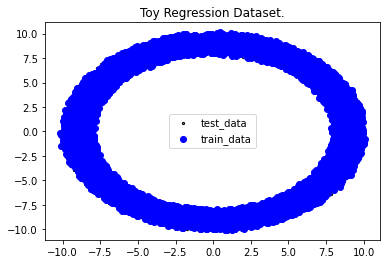

In [5]:
dm = ToyDonutDataModule(batch_size=128, n_samples=8096)

X_train, y_train, train_loader, X_test, y_test, test_loader = (
    dm.X_train,
    dm.y_train,
    dm.train_dataloader(),
    dm.X_test,
    dm.y_test,
    dm.test_dataloader(),
)

fig, ax = plt.subplots(1)
ax.scatter(X_test, y_test, color="gray", edgecolor="black", s=5, label="test_data")
ax.scatter(X_train, y_train, color="blue", label="train_data")
plt.title("Toy Regression Dataset.")
plt.legend()


# Models

## MLP

In [69]:
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim=1):
        super(MLP, self).__init__()
        
        assert out_dim==1, 'out_dim must be 1'
        
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        self.linear1 = nn.Linear(self.in_dim, self.hidden_dim)
        self.linear2 = nn.Linear(self.hidden_dim, 2*self.hidden_dim)
        self.linear3 = nn.Linear(2*self.hidden_dim, self.hidden_dim)
        self.linear4 = nn.Linear(self.hidden_dim, self.out_dim)
    
    def forward(self, x):
        x = nn.ReLU()(self.linear1(x))
        x = nn.ReLU()(self.linear2(x))
        x = nn.ReLU()(self.linear3(x))
        x = self.linear4(x)
        x = x
        return x

In [70]:
mlp = MLP(train_x.shape[1], 256, 1).to(device)
optimizer = Adam(mlp.parameters(), lr=0.01)
mae_loss = nn.MSELoss()

In [71]:
import time

In [74]:
scale_batch = train_loader.dataset.X.shape[0]//train_loader.batch_size+1

In [76]:
epochs = 2000
#to plot loss curve after training
valid_losses = []

for epoch in range(epochs):
    start_time = time.time()
    mlp.train()
#     num_batch = train_dataloader.dataset.X.shape[0] // train_dataloader.batch_size + 1


    
#     for batch_id, (batch_x, batch_y) in enumerate(train_dataloader):
    for x in train_loader:
        
        batch_x, batch_y = x['input'].to(device), x['target'].to(device)
        batch_size = batch_x.shape[0]
        
        y_pred = mlp(batch_x)

        loss = mae_loss(y_pred, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        elapsed_time = time.time() - start_time
        elapsed_min = int(elapsed_time / 60)
        elapsed_sec = elapsed_time - 60 * elapsed_min
    
    if epoch%200 == 0:

        print('\rEpoch:{} Loss:{:.4f} Time:{}m{:.2f}s'.format(epoch + 1, loss.item(),
                                                                          elapsed_min, elapsed_sec), end='')
        print()
        
    mlp.eval()
    valid_loss = 0
    
#     for batch_id, (batch_x, batch_y) in enumerate(valid_dataloader):
    for x in test_loader:
        
        batch_x, batch_y = x['input'].to(device), x['target'].to(device)
        
        y_pred = mlp(batch_x)
        loss = mae_loss(y_pred, batch_y)
        valid_loss += loss.item()
    
    valid_loss /= scale_batch
    valid_losses.append(valid_loss)
    
    #save model when validation loss is minimum
#     if valid_loss < best_loss:
#         best_loss = valid_loss
#         torch.save(mlp.state_dict(), 'mlp.model')  

    if epoch%200 == 0:
        print('Valid Loss:{:.4f}'.format(valid_loss))

Epoch:1 Loss:34.5515 Time:0m0.13s
Valid Loss:16.6702
Epoch:201 Loss:35.2160 Time:0m0.09s
Valid Loss:16.5581
Epoch:401 Loss:35.2160 Time:0m0.09s
Valid Loss:16.5581


KeyboardInterrupt: 

In [98]:
y_pred = mlp(X_test)
y_pred = y_pred.detach().numpy()

## Diffusion Model

In [6]:
n_steps = 500
cat_x = True
cat_y_pred = True

x_dim = 1
y_dim = 1
z_dim = 2

hid_layers = [128, 128]

# betas
beta_schedule = "linear"
beta_start = 0.0001
beta_end = 0.02

# testing
n_z_samples = 100

### Determenistic Model
#### Simple 1->128->128->1 with LeakyReLU

In [7]:
class DeterministicFeedForwardNeuralNetwork(nn.Module):

    def __init__(self, dim_in, dim_out, hid_layers,
                 use_batchnorm=False, negative_slope=0.01, dropout_rate=0):
        super(DeterministicFeedForwardNeuralNetwork, self).__init__()
        self.dim_in = dim_in  # dimension of nn input
        self.dim_out = dim_out  # dimension of nn output
        self.hid_layers = hid_layers  # nn hidden layer architecture
        self.nn_layers = [self.dim_in] + self.hid_layers  # nn hidden layer architecture, except output layer
        self.use_batchnorm = use_batchnorm  # whether apply batch norm
        self.negative_slope = negative_slope  # negative slope for LeakyReLU
        self.dropout_rate = dropout_rate
        layers = self.create_nn_layers()
        self.network = nn.Sequential(*layers)

    def create_nn_layers(self):
        layers = []
        for idx in range(len(self.nn_layers) - 1):
            layers.append(nn.Linear(self.nn_layers[idx], self.nn_layers[idx + 1]))
            if self.use_batchnorm:
                layers.append(nn.BatchNorm1d(self.nn_layers[idx + 1]))
            layers.append(nn.LeakyReLU(negative_slope=self.negative_slope))
            layers.append(nn.Dropout(p=self.dropout_rate))
        layers.append(nn.Linear(self.nn_layers[-1], self.dim_out))
        return layers

    def forward(self, x):
        return self.network(x)


#### Descriprion of scheduller 
* betta uniform 
* scheduller - randit (0, max_step) /2 + inverse randit (0, max_step) /2

#### Descriprion of q_sampler logic
IN:
* y_true
* y_0 from Deterministic Model 
* alphas bar sqrt = betas(variance) cumprod alpha1, alpha1*alpha2, etc
* scheduller 
* and gaussian noise
Produced Functions:
* EXTRACT:
-- extract from alphabar scheduller in torch size(batch_size)
-- extract from 1-alphabar scheduller in torch size(batch_size)
* $$
\text{eventually return:} \quad y_t = \sqrt{\bar{\alpha_t}} * y + (1 - \sqrt{\bar{\alpha_t}}) * \bar{y_0} + \sqrt{1 - \bar{\alpha_t}} * noise
$$
* $$
q(y_t | y_0, f_{\varphi}(x)) = \mathcal{N}(y_t; \sqrt{\bar{\alpha_t}}y_0 + (1 − \sqrt{\bar{\alpha_t}})f_{\varphi}(x), (1 − \bar{\alpha_t})\mathcal{I})
$$

#### Descriprion of Conditional Linear module
Init:
* y_t_sample
* y_0 from Deterministic Model 
* x sample
* beta scheduler 

Forward:
* Linear Layer (in, out)
* step EmbeddingLayer (num_beta_steps, out)
* get embeddings from scheduller (batch_size, out)
* get linear out (batch_size, out)
* apply mask linear_out * embedding_out (batch_sizem out)
#### Descriprion of Conditional Guided Linear Wrapper 
* Conditional Linear Layers (3, 128, scheduller), (128,128, scheduller)x2, (128,1)
#### Training Wrap
* Try to minimize injected noise due to schedullers into Guided Con Model via q sampler method
* Optimizer to Conditional loss from error betta estimation
* Optimizer to Deterministic loss from q sample y_t estimation

In [8]:
class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, t):
        out = self.lin(x)
        gamma = self.embed(t)
        out = gamma.view(-1, self.num_out) * out
        return out

In [9]:
class ConditionalGuidedModel(nn.Module):
    def __init__(self, n_steps: int, cat_x: bool, cat_y_pred: bool, x_dim: int, y_dim: int):
        super(ConditionalGuidedModel, self).__init__()
        # n_steps = config.diffusion.timesteps + 1
        # self.cat_x = config.model.cat_x
        # self.cat_y_pred = config.model.cat_y_pred
        self.cat_x = cat_x
        self.cat_y_pred = cat_y_pred
        data_dim = y_dim
        if self.cat_x:
            data_dim += x_dim
        if self.cat_y_pred:
            data_dim += y_dim
        self.lin1 = ConditionalLinear(data_dim, 128, n_steps)
        self.lin2 = ConditionalLinear(128, 128, n_steps)
        self.lin3 = ConditionalLinear(128, 128, n_steps)
        self.lin4 = nn.Linear(128, 1)

    def forward(self, x, y_t, y_0_hat, t):
        if self.cat_x:
            if self.cat_y_pred:
                eps_pred = torch.cat((y_t, y_0_hat, x), dim=1)
            else:
                eps_pred = torch.cat((y_t, x), dim=1)
        else:
            if self.cat_y_pred:
                eps_pred = torch.cat((y_t, y_0_hat), dim=1)
            else:
                eps_pred = y_t
        eps_pred = F.softplus(self.lin1(eps_pred, t))
        eps_pred = F.softplus(self.lin2(eps_pred, t))
        eps_pred = F.softplus(self.lin3(eps_pred, t))
        return self.lin4(eps_pred)

diff_model = ConditionalGuidedModel(n_steps=n_steps, cat_x=cat_x, cat_y_pred=cat_y_pred, x_dim=x_dim, y_dim=y_dim)
diff_model.to(device)

ConditionalGuidedModel(
  (lin1): ConditionalLinear(
    (lin): Linear(in_features=3, out_features=128, bias=True)
    (embed): Embedding(500, 128)
  )
  (lin2): ConditionalLinear(
    (lin): Linear(in_features=128, out_features=128, bias=True)
    (embed): Embedding(500, 128)
  )
  (lin3): ConditionalLinear(
    (lin): Linear(in_features=128, out_features=128, bias=True)
    (embed): Embedding(500, 128)
  )
  (lin4): Linear(in_features=128, out_features=1, bias=True)
)

## Conditional Prediction Model

In [10]:
cond_pred_model = DeterministicFeedForwardNeuralNetwork(dim_in=x_dim, dim_out=y_dim, hid_layers=hid_layers)
cond_pred_model.to(device)

DeterministicFeedForwardNeuralNetwork(
  (network): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Dropout(p=0, inplace=False)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)

# Pretraining the Conditional Prediction Model

In [11]:
n_pretrain_epochs = 2_000
aux_optimizer = Adam(cond_pred_model.parameters(), lr=0.001)
aux_cost_fn = nn.MSELoss()
cond_pred_model.train()

bar = trange(n_pretrain_epochs, leave=True)
for epoch in bar:
    for sample in train_loader:
        x, y = sample['input'].to(device), sample['target'].to(device)
        y_pred = cond_pred_model(x)
        aux_cost = aux_cost_fn(y_pred, y)

        aux_optimizer.zero_grad()
        aux_cost.backward()
        aux_optimizer.step()
        bar.set_description(f"Loss: {aux_cost.item()}")

Loss: 35.98877716064453: 100%|██████████████| 2000/2000 [02:55<00:00, 11.38it/s]


# Noise Scheduling

In [12]:
betas = torch.linspace(beta_start, beta_end, n_steps).to(device)
betas_sqrt = torch.sqrt(betas)
alphas = 1.0 - betas
alphas_cumprod = alphas.cumprod(dim=0)
alphas_bar_sqrt = torch.sqrt(alphas_cumprod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_cumprod)

# Diffusion Training

In [13]:
n_epochs = 5000

optimizer = Adam(diff_model.parameters(), lr=0.01)

diff_bar = trange(n_epochs, leave=True)
diff_model.train()
for epoch in diff_bar:
    for sample in train_loader:
        x, y = sample['input'].to(device), sample['target'].to(device)
        batch_size = x.shape[0]

        # antithetic sampling
        ant_samples_t = torch.randint(
            low=0, high=n_steps, size=(batch_size//2 + 1,)
        ).to(device)
        ant_samples_t = torch.cat([ant_samples_t, n_steps - 1 - ant_samples_t], dim=0)[:batch_size]
        

        # noise estimation loss
        y_0_hat = cond_pred_model(x)

        e = torch.randn_like(y)
        y_t_sample = q_sample(y, y_0_hat, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, ant_samples_t, noise=e)

        model_output = diff_model(x, y_t_sample, y_0_hat, ant_samples_t)

        # use the same noise sample e during training to compute loss
        loss = (e - model_output).square().mean()

        # optimize diffusion model that predicts eps_theta
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # optimize non-linear guidance model
        aux_cost = aux_cost_fn(cond_pred_model(x), y)
        aux_optimizer.zero_grad()
        aux_cost.backward()
        aux_optimizer.step()
        
        if epoch%100 ==0:
            

            diff_bar.set_description(f"Loss: {loss.item()}", refresh=True)

Loss: 0.46565061807632446: 100%|████████████| 5000/5000 [13:40<00:00,  6.10it/s]


# Diffusion Evaluation

In [42]:
n_z_samples = 2

In [43]:
def forward_predict(X_test_):
    with torch.no_grad():
        y_0_hat = cond_pred_model(X_test_)

        if X_test.dim() == 2:
            # TODO: This works for Vector 1D Regression with the tiling
            # y_0_tile = torch.tile(y, (n_z_samples, 1))

            y_0_hat_tile = torch.tile(y_0_hat, (n_z_samples, 1)).to(device)
            test_x_tile = torch.tile(X_test_, (n_z_samples, 1)).to(device)

            z = torch.randn_like(y_0_hat_tile).to(device)

            # TODO check what happens, here and why y_0_hat_tile is passed twice
            y_t = y_0_hat_tile + z

            # generate samples from all time steps for the mini-batch
            y_tile_seq = p_sample_loop(diff_model, test_x_tile, y_0_hat_tile, y_0_hat_tile, n_steps, alphas, one_minus_alphas_bar_sqrt)
            # put in shape [n_z_samples, batch_size, output_dimension]
            y_tile_seq = [
                arr.reshape(n_z_samples, X_test_.shape[0], y_t.shape[-1])
                for arr in y_tile_seq
            ]

            final_recoverd = y_tile_seq[-1]

        else:
            # TODO make this more efficient
            y_tile_seq = [
                p_sample_loop(diff_model, test_x_tile, y_0_hat_tile, 
                              y_0_hat_tile, n_steps, alphas, one_minus_alphas_bar_sqrt)[-1]
                for i in range(n_z_samples)
            ]

            final_recoverd = torch.stack(y_tile_seq, dim=0)
            
    return final_recoverd, y_tile_seq 

In [50]:
final_rec, y_tile_seq = forward_predict(X_test)
samples = y_tile_seq[-1].detach().cpu().numpy()

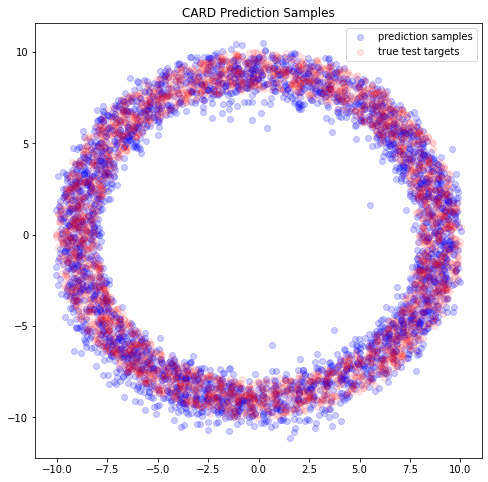

In [45]:
fig, axs = plt.subplots(1, figsize=(8, 8))


axs.scatter(
    X_test.tile(dims=(n_z_samples, 1)),
    samples.squeeze(),
    alpha=0.2,
    color="blue",
    label="prediction samples",
)
axs.scatter(X_test, y_test, label="true test targets", alpha=0.1, color="red")
axs.set_title("CARD Prediction Samples")
plt.legend()

In [55]:
X_test_red = X_test[:20]
final_rec, y_tile_seq = forward_predict(X_test_red)
samples = y_tile_seq[-1].detach().cpu().numpy()

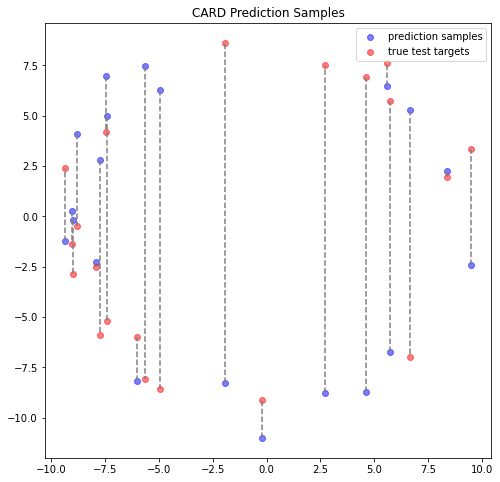

In [56]:
fig, axs = plt.subplots(1, figsize=(8, 8))


axs.scatter(
    X_test_red,
    samples.squeeze(),
    alpha=0.5,
    color="blue",
    label="prediction samples",
)
axs.scatter(X_test_red, y_test[:20], label="true test targets", alpha=0.5, color="red")
axs.set_title("CARD Prediction Samples")

array1 = [[x, y] for x, y in zip(X_test_red,
    samples.squeeze())]
array2 = [[x, y_prime] for x, y_prime in zip(X_test_red, y_test[:40].detach().numpy())]

x_coords1, y_coords1 = zip(*array1)
x_coords2, y_coords2 = zip(*array2)

for x1, y1, x2, y2 in zip(x_coords1, y_coords1, x_coords2, y_coords2):
    plt.plot([x1, x2], [y1, y2], color='gray', linestyle='--')

plt.legend()

### Plots

In [48]:
y_0_hat = cond_pred_model(X_test)

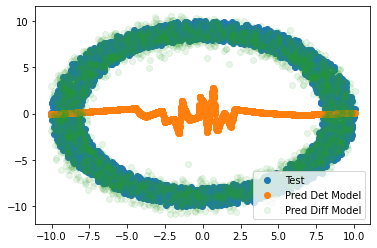

In [54]:
fig, axs = plt.subplots(1)

axs.scatter(X_test, y_test, label="Test")
axs.scatter(X_test, y_0_hat.detach().cpu().numpy(), label="Pred Det Model")

axs.scatter(X_test, samples, alpha=0.1, label="Pred Diff Model")

plt.legend()